In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import espra, plot_ellipse


In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy(q11=2, q22=2, q12=1)


(-100.0, 100.0)

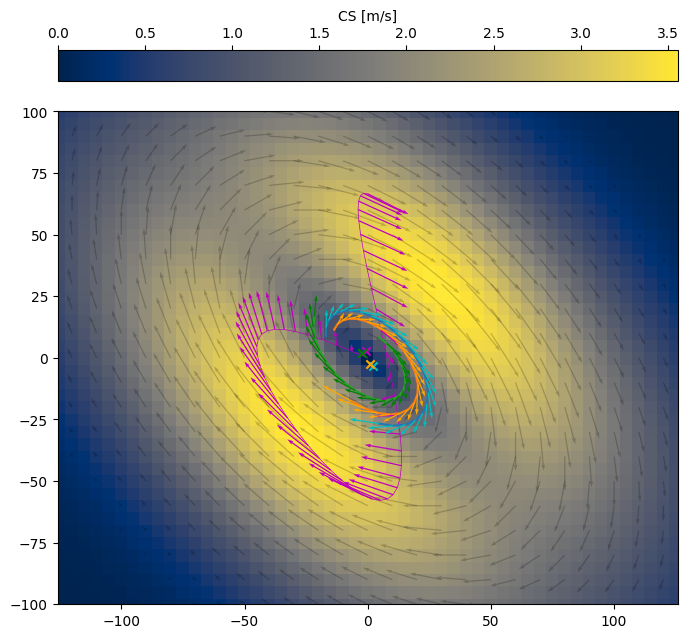

In [3]:
fig = plt.figure(figsize=(8, 8))

cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = plt.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=plt.gca(), orientation='horizontal', location='top', label='CS [m/s]')
plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

# squiggle
t = np.linspace(0, 2*np.pi, 50)
x_squig = -50 * np.sin(t) * np.cos(0.3 * t)
y_squig = 70 * np.cos(t) * np.sin(0.3 * t)
plt.plot(x_squig, y_squig, linewidth=.5, color='m')

from scipy.interpolate import RegularGridInterpolator
interp_u = RegularGridInterpolator((y, x), u.T)
interp_v = RegularGridInterpolator((y, x), v.T)
points = np.vstack([y_squig, x_squig]).T
u_squig = interp_u(points)
v_squig = interp_v(points)

spacing_squig = 1
plt.quiver(x_squig[::spacing_squig], y_squig[::spacing_squig],
           u_squig[::spacing_squig], v_squig[::spacing_squig],
           scale=scale, width=width, zorder=10, color='m')

xc, yc, w, Q, Rc, psi0 = espra(x_squig, y_squig, u_squig, v_squig)
plt.scatter(xc, yc, marker='x', color='m')

# Drifters
# Initialise N drifters
N = 3
x_d = np.random.uniform(-20, 20, N)
y_d = np.random.uniform(-20, 20, N)

# Simulation params
dt = 3
steps = 20

trajectories_x = [x_d.copy()]
trajectories_y = [y_d.copy()]
trajectories_u = [np.full(N, np.nan)]
trajectories_v = [np.full(N, np.nan)]

for _ in range(steps):
    points = np.vstack([y_d, x_d]).T
    ud = interp_u(points)
    vd = interp_v(points)

    x_d += ud * dt
    y_d += vd * dt

    trajectories_x.append(x_d.copy())
    trajectories_y.append(y_d.copy())
    trajectories_u.append(ud.copy())
    trajectories_v.append(vd.copy())

# Convert to arrays
trajectories_x = np.array(trajectories_x)
trajectories_y = np.array(trajectories_y)
trajectories_u = np.array(trajectories_u)
trajectories_v = np.array(trajectories_v)


# Convert trajectories to arrays
trajectories_x = np.array(trajectories_x)
trajectories_y = np.array(trajectories_y)
colors = ['c', 'orange', 'g']
for dd, d in enumerate(range(trajectories_x.shape[1])):
    plt.plot(trajectories_x[:,d], trajectories_y[:,d])
    plt.quiver(trajectories_x[:,d], trajectories_y[:,d],
               trajectories_u[:,d], trajectories_v[:,d],
                scale=scale, width=width, zorder=10, color=colors[dd])
    df = pd.DataFrame({'xi': trajectories_x[:,d], 'yi': trajectories_y[:,d],
                       'ui': trajectories_u[:,d], 'vi': trajectories_v[:,d]})
    df = df.dropna()
    xc, yc, w, Q, Rc, psi0 = espra(df['xi'], df['yi'], df['ui'], df['vi'])
    plt.scatter(xc, yc, marker='x', zorder=15, color=colors[dd])

plt.axis('equal')
plt.xlim(-100, 100)
plt.ylim(-100, 100)


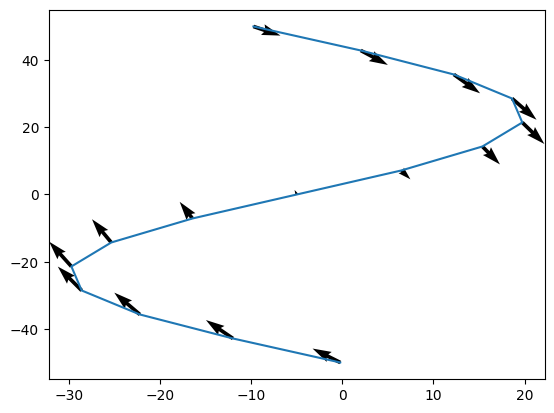

In [4]:
y_squ = np.linspace(-50, 50, 15)
x_squ = 25*np.sin(y_squ/15) - 5

plt.plot(x_squ, y_squ)

from scipy.interpolate import RegularGridInterpolator
interp_u = RegularGridInterpolator((y, x), u.T)
interp_v = RegularGridInterpolator((y, x), v.T)
points = np.vstack([y_squ, x_squ]).T
u_squ = interp_u(points)
v_squ = interp_v(points)

plt.quiver(x_squ, y_squ, u_squ, v_squ)



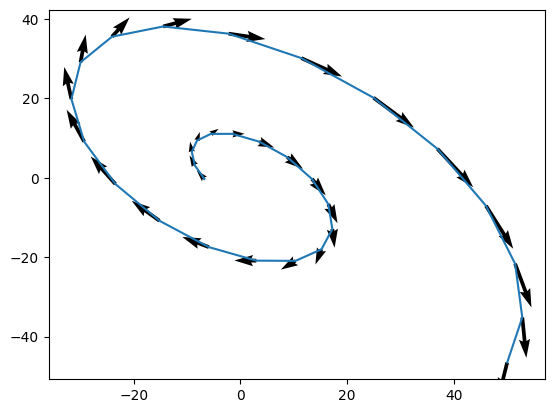

In [5]:
# drifter
N = 1
x_d = np.random.uniform(-10, 10, N)
y_d = np.random.uniform(-10, 10, N)

# Simulation params
dt = 5.2
steps = 30

trajectories_x = [x_d.copy()]
trajectories_y = [y_d.copy()]
trajectories_u = [np.full(N, np.nan)]
trajectories_v = [np.full(N, np.nan)]

for _ in range(steps):
    points = np.vstack([y_d, x_d]).T
    ud = interp_u(points)
    vd = interp_v(points)

    x_d += ud * dt
    y_d += vd * dt

    trajectories_x.append(x_d.copy())
    trajectories_y.append(y_d.copy())
    trajectories_u.append(ud.copy())
    trajectories_v.append(vd.copy())

# Convert to arrays
x_drif = np.array(trajectories_x)[1:]
y_drif = np.array(trajectories_y)[1:]
u_drif = np.array(trajectories_u)[1:]
v_drif = np.array(trajectories_v)[1:]


x_drif = [val[0] for val in x_drif]
y_drif = [val[0] for val in y_drif]
u_drif = [val[0] for val in u_drif]
v_drif = [val[0] for val in v_drif]

plt.plot(x_drif, y_drif)
plt.quiver(x_drif, y_drif, u_drif, v_drif)


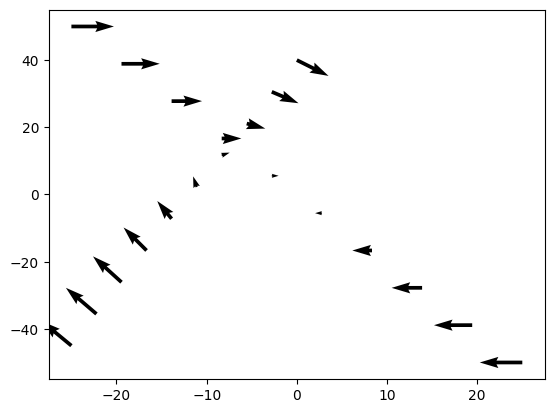

In [6]:
scaling = 5

x_l1 = np.linspace(-5*scaling, 0*scaling, 10)
y_l1 = np.linspace(-9*scaling, 8*scaling, 10)
points = np.vstack([y_l1, x_l1]).T
u_l1 = interp_u(points)
v_l1 = interp_v(points)
plt.quiver(x_l1, y_l1, u_l1, v_l1)

x_l2 = np.linspace(-5*scaling, 5*scaling, 10)
y_l2 = np.linspace(10*scaling, -10*scaling, 10)
points = np.vstack([y_l2, x_l2]).T
u_l2 = interp_u(points)
v_l2 = interp_v(points)
plt.quiver(x_l2, y_l2, u_l2, v_l2)

# x_l3 = np.linspace(-7.5*2, 7.5*2, 10)
# y_l3 = np.linspace(10*6, -5*6, 10) + 5
# points = np.vstack([y_l3, x_l3]).T
# u_l3 = interp_u(points)
# v_l3 = interp_v(points)
# plt.quiver(x_l3, y_l3, u_l3, v_l3)


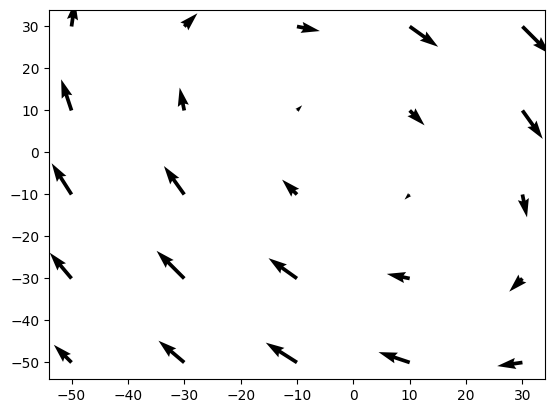

In [7]:
x_p = np.arange(-50, 50, 20)
y_p = np.arange(-50, 50, 20)
x_p, y_p = np.meshgrid(x_p, y_p)
x_p, y_p = x_p.flatten(), y_p.flatten()
points = np.vstack([y_p, x_p]).T
u_p = interp_u(points)
v_p = interp_v(points)
plt.quiver(x_p, y_p, u_p, v_p)


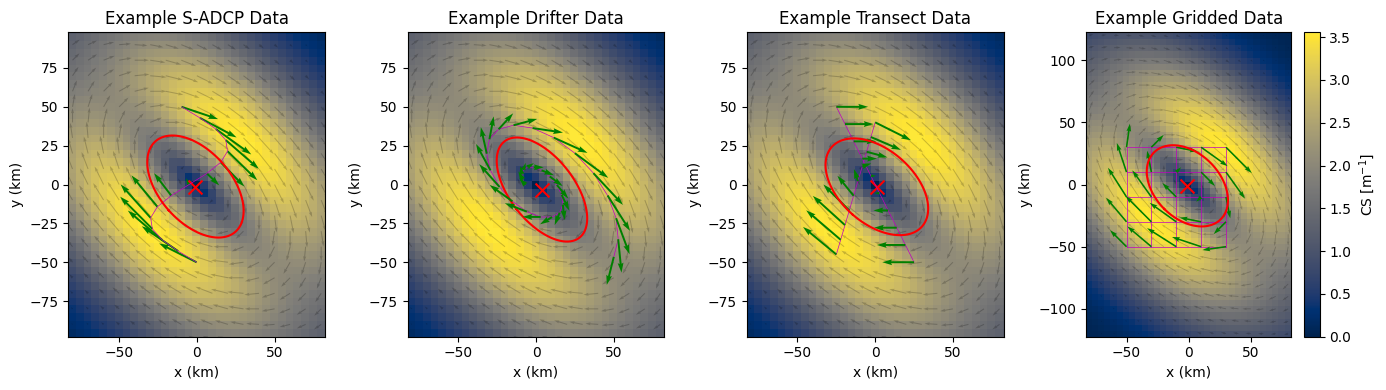

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(14,4))

cmap = 'cividis'
spacing, scale, width = 2, 40, 0.004 #0.004
for a, ax in enumerate(axs):
    pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
    if a == 3:
        plt.colorbar(pc, ax=ax, orientation='vertical', location='right', label=r'CS [m$^{-1}$]')
    ax.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
                   alpha=0.2, scale=scale, width=width, zorder=1)

    ax.axis('equal')
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
wid = 1.9

axs[0].plot(x_squ, y_squ, 'm', linewidth=.5)
axs[0].quiver(x_squ, y_squ, u_squ, v_squ, scale=scale*.5, width=width*wid, color='g')
xc, yc, w, Q, Rc, psi0 = espra(x_squ, y_squ, u_squ, v_squ)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(xc, yc, marker='x', s=100, color='r')
axs[0].set_title('Example S-ADCP Data')

axs[1].plot(x_drif, y_drif, 'm', linewidth=.5)
axs[1].quiver(x_drif, y_drif, u_drif, v_drif, scale=scale*.5, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_drif, y_drif, u_drif, v_drif)
axs[1].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[1].plot(x_ell, y_ell, 'r')
axs[1].set_title('Example Drifter Data')

axs[2].plot(x_l1, y_l1, 'm', linewidth=.5)
axs[2].plot(x_l2, y_l2, 'm', linewidth=.5)
axs[2].quiver(x_l1, y_l1, u_l1, v_l1, scale=scale*.5, width=width*wid, color='g', zorder=3)
axs[2].quiver(x_l2, y_l2, u_l2, v_l2, scale=scale*.5, width=width*wid, color='g', zorder=3)
# axs[2].quiver(x_l3, y_l3, u_l3, v_l3, scale=scale, width=width)
xc, yc, w, Q, Rc, psi0 = espra(list(x_l1) + list(x_l2), list(y_l1) + list(y_l2),
                               list(u_l1) + list(u_l2), list(v_l1) + list(v_l2))
axs[2].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[2].plot(x_ell, y_ell, 'r', zorder=3)
axs[2].set_title('Example Transect Data')

axs[3].plot([x_p[0], x_p[4]], [y_p[0], y_p[4]], 'm', linewidth=.5)
axs[3].plot([x_p[5], x_p[9]], [y_p[5], y_p[9]], 'm', linewidth=.5)
axs[3].plot([x_p[10], x_p[14]], [y_p[10], y_p[14]], 'm', linewidth=.5)
axs[3].plot([x_p[15], x_p[19]], [y_p[15], y_p[19]], 'm', linewidth=.5)
axs[3].plot([x_p[20], x_p[24]], [y_p[20], y_p[24]], 'm', linewidth=.5)

axs[3].plot([x_p[0], x_p[20]], [y_p[0], y_p[20]], 'm', linewidth=.5)
axs[3].plot([x_p[1], x_p[21]], [y_p[1], y_p[21]], 'm', linewidth=.5)
axs[3].plot([x_p[2], x_p[22]], [y_p[2], y_p[22]], 'm', linewidth=.5)
axs[3].plot([x_p[3], x_p[23]], [y_p[3], y_p[23]], 'm', linewidth=.5)
axs[3].plot([x_p[4], x_p[24]], [y_p[4], y_p[24]], 'm', linewidth=.5)
axs[3].quiver(x_p, y_p, u_p, v_p, scale=scale*.5, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_p, y_p, u_p, v_p)
axs[3].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[3].plot(x_ell, y_ell, 'r', zorder=3)
axs[3].set_title('Example Gridded Data')

plt.tight_layout()


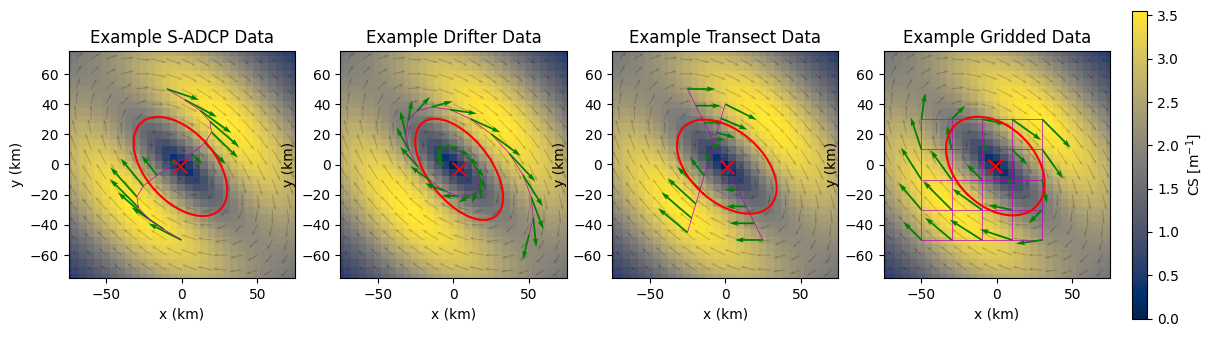

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# your data arrays: x, y, u, v, x_squ, y_squ, u_squ, v_squ, x_drif, y_drif, u_drif, v_drif,
# x_l1, y_l1, u_l1, v_l1, x_l2, y_l2, u_l2, v_l2, x_p, y_p, u_p, v_p, etc.

fig, axs = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=False)

cmap = 'cividis'
spacing, scale, width = 2, 40, 0.004
wid = 1.9

# Plot everything but defer the colorbar until after the loop
for a, ax in enumerate(axs):
    pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
    ax.quiver(
        x[::spacing], y[::spacing],
        u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
        alpha=0.2, scale=scale, width=width, zorder=1
    )
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# --- Panel 1: Example S-ADCP Data ---
axs[0].plot(x_squ, y_squ, 'm', linewidth=.5)
axs[0].quiver(x_squ, y_squ, u_squ, v_squ, scale=scale*0.5, width=width*wid, color='g')
xc, yc, w, Q, Rc, psi0 = espra(x_squ, y_squ, u_squ, v_squ)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(xc, yc, marker='x', s=100, color='r')
axs[0].set_title('Example S-ADCP Data')

# --- Panel 2: Example Drifter Data ---
axs[1].plot(x_drif, y_drif, 'm', linewidth=.5)
axs[1].quiver(x_drif, y_drif, u_drif, v_drif, scale=scale*0.5, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_drif, y_drif, u_drif, v_drif)
axs[1].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[1].plot(x_ell, y_ell, 'r')
axs[1].set_title('Example Drifter Data')

# --- Panel 3: Example Transect Data ---
axs[2].plot(x_l1, y_l1, 'm', linewidth=.5)
axs[2].plot(x_l2, y_l2, 'm', linewidth=.5)
axs[2].quiver(x_l1, y_l1, u_l1, v_l1, scale=scale*0.5, width=width*wid, color='g', zorder=3)
axs[2].quiver(x_l2, y_l2, u_l2, v_l2, scale=scale*0.5, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(
    list(x_l1) + list(x_l2),
    list(y_l1) + list(y_l2),
    list(u_l1) + list(u_l2),
    list(v_l1) + list(v_l2)
)
axs[2].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[2].plot(x_ell, y_ell, 'r', zorder=3)
axs[2].set_title('Example Transect Data')

# --- Panel 4: Example Gridded Data ---
for i in range(0, 25, 5):
    axs[3].plot([x_p[i], x_p[i+4]], [y_p[i], y_p[i+4]], 'm', linewidth=.5)
for i in range(5):
    axs[3].plot([x_p[i], x_p[i+20]], [y_p[i], y_p[i+20]], 'm', linewidth=.5)
axs[3].quiver(x_p, y_p, u_p, v_p, scale=scale*0.5, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_p, y_p, u_p, v_p)
axs[3].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[3].plot(x_ell, y_ell, 'r', zorder=3)
axs[3].set_title('Example Gridded Data')

# --- Single colorbar for all panels ---
# Use `ax=axs` so it spans the entire row; adjust fraction/pad to taste
fig.colorbar(
    pc,
    ax=axs,
    orientation='vertical',
    fraction=0.02,
    pad=.02,
    label=r'CS [m$^{-1}$]'
)

# plt.tight_layout()
plt.show()




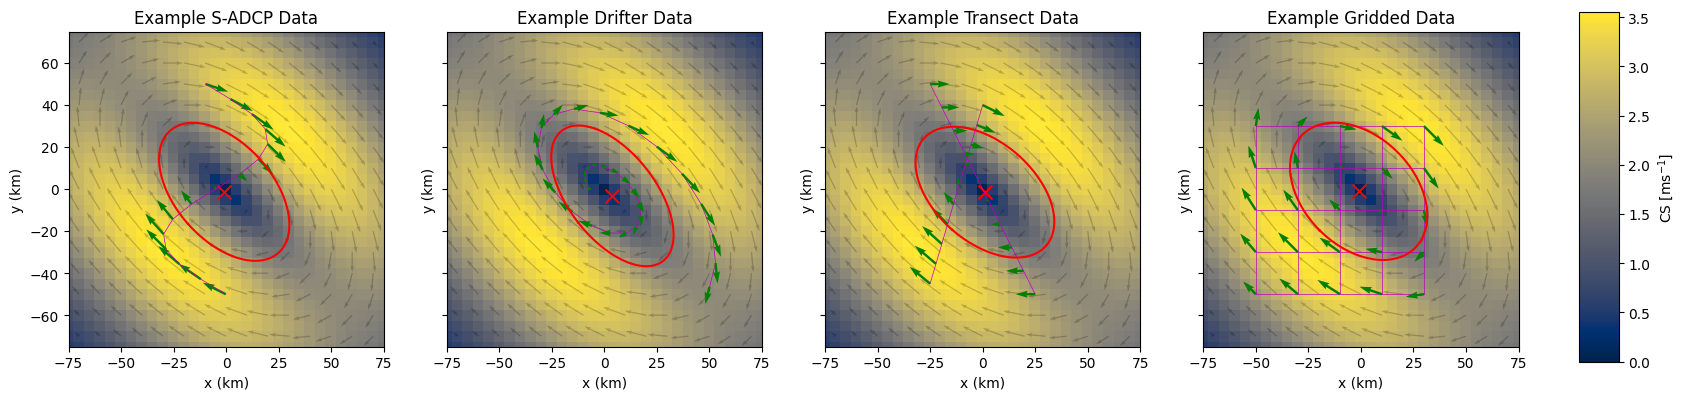

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# your data arrays: x, y, u, v, x_squ, y_squ, u_squ, v_squ, x_drif, y_drif, u_drif, v_drif,
# x_l1, y_l1, u_l1, v_l1, x_l2, y_l2, u_l2, v_l2, x_p, y_p, u_p, v_p, etc.

fig, axs = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=False, sharey=True, sharex=True)

cmap = 'cividis'
spacing, scale, width = 2, 40, 0.004
wid = 1.9

# ---- plot background pcolor + quiver on each axis ----
for ax in axs:
    pc = ax.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
    ax.quiver(
        x[::spacing], y[::spacing],
        u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
        alpha=0.2, scale=scale, width=width, zorder=1
    )
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# ---- Panel 1: Example S-ADCP Data ----
axs[0].plot(x_squ, y_squ, 'm', linewidth=.5)
axs[0].quiver(x_squ, y_squ, u_squ, v_squ, scale=scale*1, width=width*wid, color='g')
xc, yc, w, Q, Rc, psi0 = espra(x_squ, y_squ, u_squ, v_squ)
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[0].plot(x_ell, y_ell, 'r')
axs[0].scatter(xc, yc, marker='x', s=100, color='r')
axs[0].set_title('Example S-ADCP Data')

# ---- Panel 2: Example Drifter Data ----
axs[1].plot(x_drif, y_drif, 'm', linewidth=.5)
axs[1].quiver(x_drif, y_drif, u_drif, v_drif, scale=scale*1, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_drif, y_drif, u_drif, v_drif)
axs[1].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[1].plot(x_ell, y_ell, 'r', zorder=3)
axs[1].set_title('Example Drifter Data')

# ---- Panel 3: Example Transect Data ----
axs[2].plot(x_l1, y_l1, 'm', linewidth=.5)
axs[2].plot(x_l2, y_l2, 'm', linewidth=.5)
axs[2].quiver(x_l1, y_l1, u_l1, v_l1, scale=scale*1, width=width*wid, color='g', zorder=3)
axs[2].quiver(x_l2, y_l2, u_l2, v_l2, scale=scale*1, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(
    list(x_l1) + list(x_l2),
    list(y_l1) + list(y_l2),
    list(u_l1) + list(u_l2),
    list(v_l1) + list(v_l2)
)
axs[2].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[2].plot(x_ell, y_ell, 'r', zorder=3)
axs[2].set_title('Example Transect Data')

# ---- Panel 4: Example Gridded Data ----
# horizontal transects
for i in range(0, 25, 5):
    axs[3].plot([x_p[i], x_p[i+4]], [y_p[i], y_p[i+4]], 'm', linewidth=.5)
# vertical transects
for i in range(5):
    axs[3].plot([x_p[i], x_p[i+20]], [y_p[i], y_p[i+20]], 'm', linewidth=.5)
axs[3].quiver(x_p, y_p, u_p, v_p, scale=scale*1, width=width*wid, color='g', zorder=3)
xc, yc, w, Q, Rc, psi0 = espra(x_p, y_p, u_p, v_p)
axs[3].scatter(xc, yc, marker='x', s=100, color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=40)
axs[3].plot(x_ell, y_ell, 'r', zorder=3)
axs[3].set_title('Example Gridded Data')

# ---- now place one colorbar to the right of the entire figure ----
# leave room on the right
fig.subplots_adjust(right=0.85)

# [left, bottom, width, height] in figure coords
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, orientation='vertical', label=r'CS [ms$^{-1}$]')

plt.show()
